# Extracting quantitative information from the Southern blot data

To make any quantitative assessment of the telomere packing, we need to know the distribution of genomic lengths that the telomeres can have.

In principle, the Southern blot data can provide us information on this distribution. However, due to some technical considerations, the interpretation of the blots is not straight forward. In this worksheet I will develop the theory that lets us determine the mean and standard deviation of the genomic lengths distribution from the Southern blot data and apply it to the telomere blots.

In [1]:
# Import libraries for numerics and plotting
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Theory of quantitative Southern blots

**Note:** This analysis should produce identical results as the one in [Kimura, et al., "Measurement of telomere length by the Southern blot analysis of terminal restriction fragement lengths," Nature Protocols, 5, 1596 (2010)](http://www.nature.com/nprot/journal/v5/n9/full/nprot.2010.124.html)

Let's consider how a Southern blot "signal" is generated. By signal I mean the (inverse) line profile taken through an image of the blot.

First, one has a probability density function that describes how long a given telomere is if one were to randomly pick a telomere out of a pool of telomeres. This density function is written as $p \left( L \right)$ with $L$ being the genomic length of the telomere. We want to know something about $p \left( L \right)$, but what we have is a Southern blot signal, which I denote by $s \left( L \right)$.

The primary complication comes from this fact: more probes can bind to longer telomeres, so longer telomeres will have more signal than shorter telomeres. An intuitive example would be to consider a population of two telomeres, one that is 1 kb long and one that is 5 kb long. The probability of picking either telomere is 1/2; they have equal probability. However, the signal coming from the 5 kb telomere will have $\frac{5}{l}$ times more signal, where $l$ is the average probe length, because more probes can bind to it. Thus, our Southern blot will report a higher value at 5 kb than at 1 kb.

I expect that the total amount of radioactivity for one value of the genomic length $L$ should be proportional to the number of probes at the same value. The number of probes is the total number of telomeres in the population with that length, multiplied by the number of probes that can bind to a telomere at that length. The first quantity, the number of telomeres, is $N_{telomeres} \times p \left( L \right)$, where $N_{telomeres}$ is the total number of telomeres in my pool. The second quantity, the number of probes of length $l$ that can bind to a telomere of length $L$, is $\frac{L}{l}$. This means that the total number of probes for a given genomic length and population of telomeres is

\begin{equation}
N_{probes} \left( L \right) = N_{telomeres} \times p \left( L \right) \times \frac{L}{l}
\end{equation}

The signal that we measure in the Southern is related to this quantity, but is not necessarily proportional to it. This is because the real signal has a lower limit (the noise floor) and an upper limit (the saturation point) which the signal cannot excede.

Since we haven't done any measurements on the saturation of the phosphor screen, we'll assume that the only nonlinearity is the noise floor. An illustration of this is below:

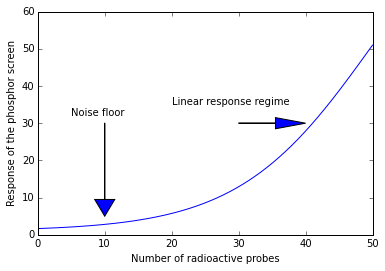

In [2]:
# Example is a logistic function that is linear at mid-range x values with a noise floor and saturation point
# (I cropped the large x-values since we don't know the saturation point for this illustration.)
x = np.linspace(0, 50, 1e5)

# The noise floor is set to one here.
example = 1 + 1e2 / (1 + np.exp(-0.1*(x-50)))

plt.plot(x, example)
plt.xlabel('Number of radioactive probes')
plt.ylabel('Response of the phosphor screen')

plt.arrow(10, 30, 0, -25, head_width = 3, length_includes_head = True)
plt.annotate('Noise floor', (5, 32))

plt.arrow(30, 30, 10, 0, head_width = 3, length_includes_head = True)
plt.annotate('Linear response regime', (20, 35))
plt.show()

The Southern blot signal can be written as a composition of two functions: the first is the response of the phosphor screen, which I call $r \left( N_{probes} \right)$, and the second is the number of probes as a function of the genomic length described above, $N_{probes} \left( L \right) = N_{telomeres} \times p \left( L \right) \times \frac{L}{l}$. The Southern blot signal is thus

\begin{equation}
s \left( L \right) = \left( r \circ N_{probes} \right) \left( L \right)
\end{equation}

**The goal is take measured the signal $s \left( L \right)$ and determine $p \left( L \right)$ from it.** Of course, this is a simplified model which ignores the impulse response of the blot and the smearing that's usually observed behind a blot in the track.

Because of the simplifications in the model, we'll only estimate the mean and standard deviation of $p \left( L \right)$, rather than the full shape of $p \left( L \right)$ itself. These are the only values necessary for the simulations, anyway.

## Determining telomere length distributions

From the theory, we know that a line profile through the Southern blot images is related to the distribution of the telomere genomic lengths, weighted by a linear factor and subject to noise and plate saturation.

The goal is to take the Southern blot line profile, $s \left( L \right)$ and obtain the distribution of genomic lengths, $p \left( L \right)$.

A simple assumption is that we are in the linear regime of the plate response and subject only to noise. In this case, the (inverse) line profile is proportional to the distribution and a weighting factor equivalent to $\frac{L}{l}$, all with a constant added that represents the noise floor. The weighting factor is there because longer telomeres will have proportionately more signal than shorter ones, a result of the fact that more oligonucleotides labels can bind to longer telomeres.

Mathmetically, under the assumption of linearity and noise, we write $s \left( L \right) \sim \left[ p \left( L \right) \times \frac{L}{l} \right] + \text{noise}$, so that $p \left( L \right) \sim \frac{s \left( L \right) - \text{noise}}{L / l}$. Since we'll have to normalize by a constant, the probe length $l$ actually won't matter under these assumptions and we can write more simply

\begin{equation}
p \left( L \right) \sim \frac{s \left( L \right) - \text{noise}}{L}
\end{equation}

**This means, to get the distribution of genomic lengths for our sample of telomeres, we need to subtract the noise floor from the Southern blot signals and then divide by the genomic length.**

**Note:** In the above-cited Nature Protocols paper, they used the variable $MW$ for $L$, and $OD(corrected)$ for the quantity $s \left( L \right) - \text{noise}$. The results remain the same, however.

In [3]:
# Import (inverse) line profile data
hl    = np.loadtxt('HelaL.xls',      delimiter = '\t', skiprows = 1)
hs    = np.loadtxt('HelaS.xls',      delimiter = '\t', skiprows = 1)
scale = np.loadtxt('Ladder.xls',     delimiter = '\t', skiprows = 1)
empty = np.loadtxt('EmptyTrack.xls', delimiter = '\t', skiprows = 1)

# Invert line profiles
pxL     = hl[:,0];         blotL     = -hl[:,1] + 255
pxS     = hs[:,0];         blotS     = -hs[:,1] + 255
pxScale = scale[:,0];      blotScale = -scale[:,1] + 255
pxEmpty = empty[:,0];      blotEmpty = -empty[:,1] + 255

We have to invert the line profiles to make darker colors correspond to higher numbers. In the gray scale images, darker colors are lower numbers; taking the negative of the pixel value and adding 255 (the maximum value in an 8-bit image) is the same as finding the inverse, or complement, of the line profile.

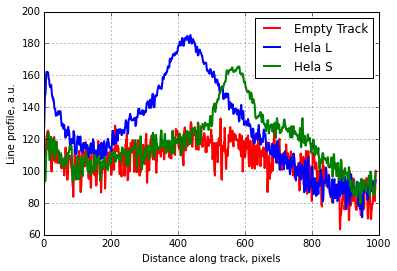

In [4]:
# Plot the profiles
plt.plot(pxEmpty, blotEmpty, 'r', label = 'Empty Track', linewidth = 2)
plt.plot(pxL,     blotL,     'b', label = 'Hela L',      linewidth = 2)
plt.plot(pxS,     blotS,     'g', label = 'Hela S',      linewidth = 2)

plt.xlabel('Distance along track, pixels')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend()
plt.show()

## Converting the x-axis to genomic length (units of kb)

### Find the ladder tick locations

I now need to convert the x-axis from pixels to genomic length, in units of kilobases. This is done with the help of the ladder profiles.

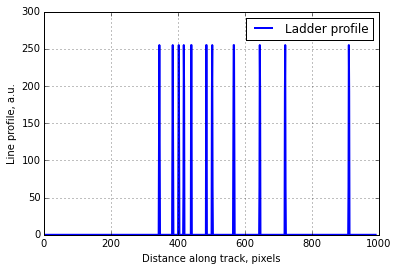

In [5]:
# Define the scale ticks
ladderTicks = np.array([48.5, 38.4, 33.4, 29.9, 24.2, 17, 15, 10, 7 ,5, 3])

# Plot the line profiles through the scales
plt.plot(pxScale, blotScale, label = 'Ladder profile', linewidth = 2)
plt.xlabel('Distance along track, pixels')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend(loc = 'best')
plt.show()

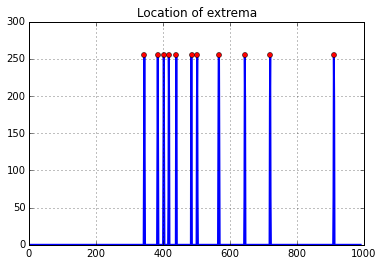

In [6]:
from scipy.signal import argrelextrema

# Find locations of the ticks in pixels
extrema = argrelextrema(blotScale, np.greater)[0]

# Filter extrema by their y-value
extrema = extrema[blotScale[extrema] > 200]

# Manually add missing points
extrema = sorted(np.append(extrema, [441, 486, 567]))

plt.plot(pxScale, blotScale, label = 'Ladder', linewidth = 2)
plt.plot(extrema, blotScale[extrema], 'ro', markersize = 5)
plt.grid(True)
plt.title('Location of extrema')
#plt.xlim((560, 580))
plt.show()

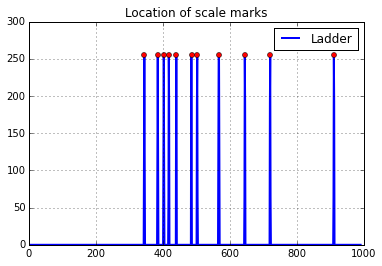

In [7]:
# Build the array of ticks corresponding to ladder marks
ticks = extrema

# Check that tick locations have been found correctly
plt.plot(pxScale, blotScale, label = 'Ladder', linewidth = 2)
plt.plot(ticks, blotScale[ticks], 'ro', markersize = 5)
plt.grid(True)
plt.title('Location of scale marks')
plt.legend(loc = 'best')
plt.show()

Now, let's fit a power law to the extrema so we can convert pixels to kilobases.

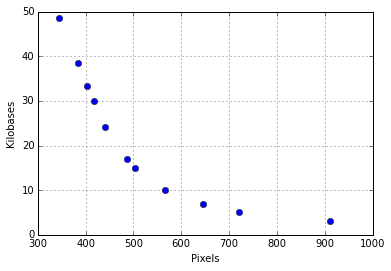

In [8]:
# Plot kilobases vs. pixels
plt.plot(ticks, ladderTicks,  'o', label = 'Ladder')
plt.xlabel('Pixels')
plt.ylabel('Kilobases')
plt.grid(True)

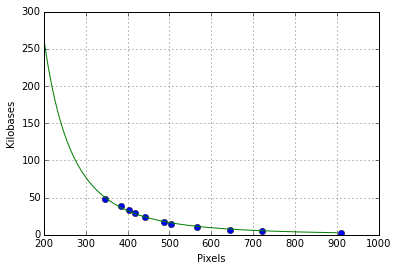

In [9]:
# Fit a power law to the above plot
def fitFunc(x, a0, a1):
    return a0 * x ** a1

xData = ticks
yData = ladderTicks

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fitFunc, xData, yData)

# Check the curve fit
x = np.arange(200, 900)
plt.plot(ticks,  ladderTicks,  'o', label = 'Ladder')
plt.plot(x, fitFunc(x, popt[0], popt[1]), label = 'Fit')
plt.xlabel('Pixels')
plt.ylabel('Kilobases')
plt.grid(True)
plt.show()

Now we have a conversion from pixels along the blot tracks to kilobases.

Let's now plot the line profiles as a function kilobases and see how they look.

/home/douglass/.virtualenvs/scipy/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


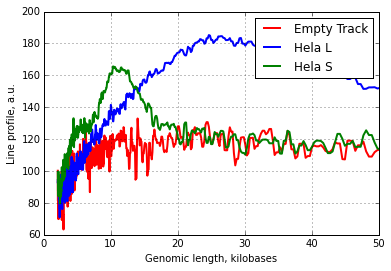

In [10]:
# Plot the profiles
plt.plot(fitFunc(pxEmpty, popt[0], popt[1]), blotEmpty, 'r', label = 'Empty Track', linewidth = 2)
plt.plot(fitFunc(pxL,     popt[0], popt[1]), blotL,     'b', label = 'Hela L',      linewidth = 2)
plt.plot(fitFunc(pxS,     popt[0], popt[1]), blotS,     'g', label = 'Hela S',      linewidth = 2)
plt.xlabel('Genomic length, kilobases')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend()
plt.xlim(0, 50)
plt.show()

## Converting a line profile into probability density

Let's first smooth the empty track data and subtract it from the curves. The empty track serves as our "noise floor."

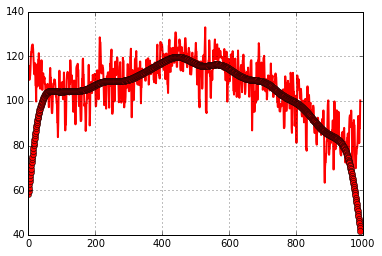

In [11]:
from scipy.signal import gaussian, convolve
#windowWidth = 20
#b = gaussian(windowWidth, 10)
windowWidth = 1000
b = gaussian(windowWidth, 30)
noisefloor = convolve(blotEmpty, b/b.sum())
noisefloor = noisefloor[(windowWidth / 2):(1-windowWidth/2)]

plt.plot(pxEmpty, blotEmpty, color = 'red', label = 'Empty track', linewidth = 2)
plt.plot(pxEmpty, noisefloor, 'ro')
#plt.xlim(0, 200)
plt.grid(True)

In [12]:
blotL     = blotL - noisefloor
blotS     = blotS - noisefloor
blotEmpty = blotEmpty - noisefloor

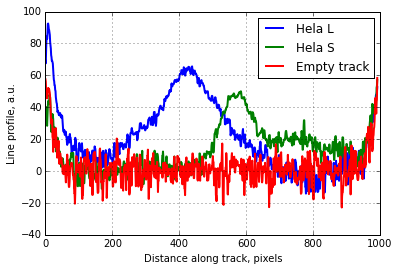

In [13]:
# Check that the noise has been subtracted
plt.plot(pxL,          blotL,          label = 'Hela L',      linewidth = 2)
plt.plot(pxS,          blotS,          label = 'Hela S',      linewidth = 2)
plt.plot(pxEmpty, blotEmpty, label = 'Empty track', linewidth = 2)
plt.xlabel('Distance along track, pixels')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend()
plt.show()

Now that we've got the noise removed, let's rescale the whole x-axis by dividing by the genomic length. This removes the bias introduced by longer telomeres having a larger signal.

We can also account for the subtelomeric fragment length, which contributes to a perceived increase in molecular weight in the gel. This is because the restriction fragment can contain the subtelomere sequence, effectively slowing it in the gel, but the hybridizing label will only attach to the true telomere repeat sequence. According to the Nature Protocols paper, an independent measurement of subtelomeric length must be made for the TRF assessment to be truly accurate.

For us, this independent measurement was the dot blot.

In [14]:
MW = fitFunc(pxL, popt[0], popt[1]) # pxL, and pxS should be identical

subTeloOffset = 3.5
MW = MW - subTeloOffset

cBlotL = blotL / MW
cBlotS = blotS / MW

# Flip arrays for convenience in cropping later
MW     = np.flipud(MW)
blotL  = np.flipud(blotL)
blotS  = np.flipud(blotS)
cBlotL = np.flipud(cBlotL)
cBlotS = np.flipud(cBlotS)

/home/douglass/.virtualenvs/scipy/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


Now we need to find where the curves cross zero, since data beyond these points are likely noise and not actually part of the distributions.

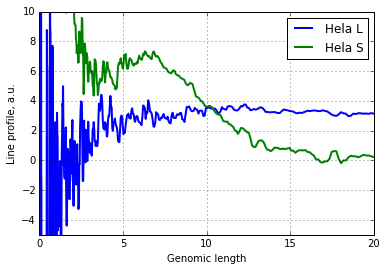

In [42]:
# Zoom into low genomic length areas to find the zero-crossing
plt.plot(MW, cBlotL, label = 'Hela L', linewidth = 2)
plt.plot(MW, cBlotS, label = 'Hela S', linewidth = 2)
plt.xlabel('Genomic length')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend(loc = 'best')
plt.xlim(0, 20)
#plt.xlim(100,200)
plt.ylim(-5,10)
plt.show()

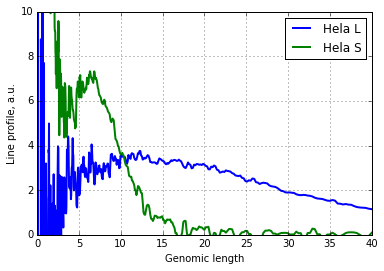

In [16]:
# Zoom to find strong discontinuities in the curves
plt.plot(MW, cBlotL, label = 'Hela L', linewidth = 2)
plt.plot(MW, cBlotS, label = 'Hela S', linewidth = 2)
plt.xlabel('Genomic length')
plt.ylabel('Line profile, a.u.')
plt.grid(True)
plt.legend(loc = 'best')
plt.xlim(0, 40)
#plt.xlim(100,200)
plt.ylim(0,10)
plt.show()

Let's crop these curves to make them easier to work with, to be more consistent with the dot blot measurements, and to remove bias introduced by undigested material and possible short, extrachromosomal telomeric DNA.

### **UPDATE THIS PARAGRAPH**

It's unlikely that telomeres are going to be greater than about 150 kb long, so we'll set this as the absolute upper limit for Hela L. Furthermore, based on the above graph and the original Southern blots, it looks like anything less than about 7 kb in Hela S is probably noise. Anything less than 10 kb in Hela L is probably noise. Setting the cropping minimums to these values will bring the mean values into agreement with the dot blots, as will be seen below. More reasoning for the cropping is that very small and very large genomic lengths are biased by over-sheared and undigested material, respectively.

In [43]:
# Both lower bounds are estimated from the points where there is a sudden spike in the noise and curve y-axis values.
# See the graph above.

cropL = (4.5, 500) # Hela L is very close to the noise floor beyond 150 kb
cropS = (4.5, 15.5) # Hela S reaches the noise at 19.5 kb and remains more-or-less constant for values > 20 kb
# Crop the arrays to make them easier to work with
MWL = MW.copy()
MWS = MW.copy()

blotLcr  = blotL[np.logical_and(MWL > cropL[0], MWL < cropL[1])]
cBlotLcr = cBlotL[np.logical_and(MWL > cropL[0], MWL < cropL[1])]

blotScr  = blotS[np.logical_and(MWS > cropS[0], MWS < cropS[1])]
cBlotScr = cBlotS[np.logical_and(MWS > cropS[0], MWS < cropS[1])]

MWL = MWL[np.logical_and(MWL > cropL[0], MWL < cropL[1])]
MWS = MWS[np.logical_and(MWS > cropS[0], MWS < cropS[1])]

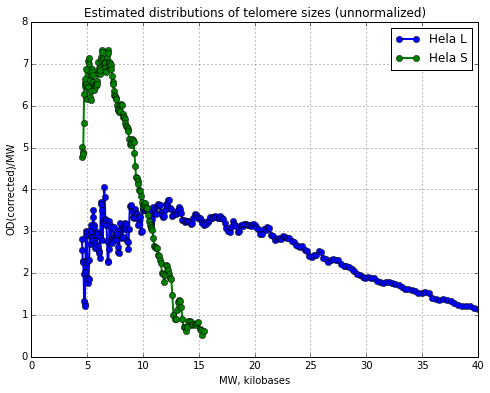

In [44]:
plt.figure(figsize = (8,6))
plt.plot(MWL, cBlotLcr, '-o', label = 'Hela L', linewidth = 2)
plt.plot(MWS, cBlotScr, '-o', label = 'Hela S', linewidth = 2)
plt.xlabel('MW, kilobases')
plt.ylabel('OD(corrected)/MW')
plt.grid(True)
plt.legend()
plt.title('Estimated distributions of telomere sizes (unnormalized)')
plt.xlim(0, 40)
plt.show()

Hela L clearly has a very long tail, which could be what contributes to the larger ratio observed in the dot blot as compared to the peak of the Southern blot OD's. Let's compute the means of these distributions.

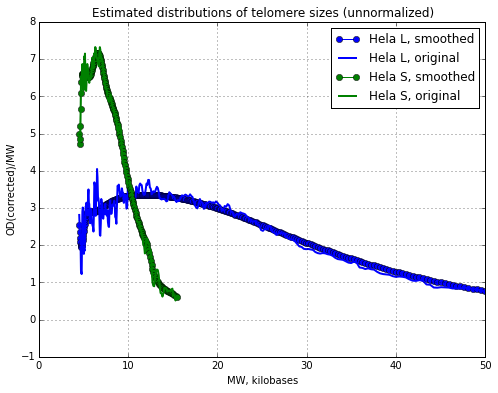

In [45]:
# Smooth the corrected curves
from scipy.interpolate import UnivariateSpline
splLcorr = UnivariateSpline(MWL, cBlotLcr)
splScorr = UnivariateSpline(MWS, cBlotScr)

splLcorr.set_smoothing_factor(20)
splScorr.set_smoothing_factor(5)

plt.figure(figsize = (8,6))
plt.plot(MWL, splLcorr(MWL), '-o', label = 'Hela L, smoothed', linewidth = 1)
plt.plot(MWL, cBlotLcr,      'b',  label = 'Hela L, original', linewidth = 2)
plt.plot(MWS, splScorr(MWS), '-o', label = 'Hela S, smoothed', linewidth = 1)
plt.plot(MWS, cBlotScr,      'g',  label = 'Hela S, original', linewidth = 2)
plt.xlabel('MW, kilobases')
plt.ylabel('OD(corrected)/MW')
plt.grid(True)
plt.legend()
plt.title('Estimated distributions of telomere sizes (unnormalized)')
plt.xlim(0, 50)
plt.show()

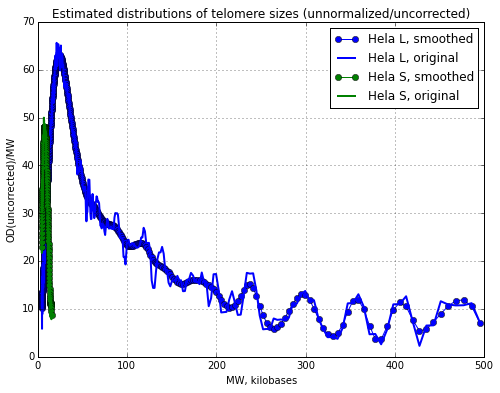

In [49]:
# Smooth the uncorrected curves
splL = UnivariateSpline(MWL, blotLcr)
splS = UnivariateSpline(MWS, blotScr)

splL.set_smoothing_factor(2000)
splS.set_smoothing_factor(500)

plt.figure(figsize = (8,6))
plt.plot(MWL, splL(MWL), '-o', label = 'Hela L, smoothed', linewidth = 1)
plt.plot(MWL, blotLcr,    'b',  label = 'Hela L, original', linewidth = 2)
plt.plot(MWS, splS(MWS), '-o', label = 'Hela S, smoothed', linewidth = 1)
plt.plot(MWS, blotScr,    'g',  label = 'Hela S, original', linewidth = 2)
plt.xlabel('MW, kilobases')
plt.ylabel('OD(uncorrected)/MW')
plt.grid(True)
plt.legend()
plt.title('Estimated distributions of telomere sizes (unnormalized/uncorrected)')
plt.xlim(0, 500)
plt.show()

In [21]:
# Final cropping of the Hela L curve
MWL = MWL[MWL < 200]

## Finding the statistics from these distributions

According the Nature protocols paper I cited above, the mean value of these distributions is

\begin{equation*}
\frac{\sum_i \left(OD_i \right)}{\sum_i \left( OD_i / MW_i\right)}
\end{equation*}

In [22]:
meanL = np.sum(splL(MWL)) / np.sum(splLcorr(MWL))
meanS = np.sum(splS(MWS)) / np.sum(splScorr(MWS))

#meanL = np.sum(blotLcr) / np.sum(cBlotLcr)
#meanS = np.sum(blotScr) / np.sum(cBlotScr)
print('Hela L mean: {0}\nHela S mean: {1}'.format(meanL, meanS))
print('The ratio of means is: {0}'.format(meanL / meanS))

Hela L mean: 18.311331554836585
Hela S mean: 7.481674064068329
The ratio of means is: 2.447491216274581


The above plot contains the **unnormalized** probability density functions for the Hela telomere genomic lengths. I should check that these values for the mean are the same as calculating a mean from a **normalized distribution**.

As mentioned in the Nat. Protocols paper, this measure underestimates the mean value. An overestimate of the mean is given by the expression

\begin{equation}
\frac{\sum_{i} \left( OD_i \times L \right)}{OD_i}
\end{equation}

In [23]:
meanL2 = np.sum(splL(MWL) * MWL) / np.sum(splL(MWL))
meanS2 = np.sum(splS(MWS) * MWS) / np.sum(splS(MWS))

#meanL2 = np.sum(blotLcr * MWL) / np.sum(blotLcr)
#meanS2 = np.sum(blotScr * MWS) / np.sum(blotScr)
print('Hela L mean (alternative): {0}\nHela S mean (alternative): {1}'.format(meanL2, meanS2))

Hela L mean (alternative): 35.730560496004095
Hela S mean (alternative): 8.167550713376862


Our dot blot data suggests that the ratio of the means should be around 3, so the two numbers for mean estimates from the Southern blots seem consistent with the dot blot data.

### Making numeric distributions from the Southern blot data

Now that we have the curves, let's turn them into distributions. We'll first convert the curves to histograms, and then normalize the histograms. This essentially creates probability mass functions.

Note that even though the genomic length and label lengths are discrete variables, it should be ok to use continuous approximations up to this point. This is because the spacing between allowed values for the genomic length (1 base pair) and probe length (about 300 bp) is much smaller than the spread of the distributions (about 10,000 base pairs). The distributions thus essentially "look" continous.

First, and unfortunately, the numpy hist function accepts histogram bin *edges* as an argument. However, we have bin *centers*. We'll have to find the edges. This is done in a log10 scale since the data was originally obtained on this scale (blot ladders have logarithmic spacings).

### The following part on bin computations is not relevant to the discussion and can be skipped.

Please proceed to the section on normalizing the histograms below.

In [24]:
# Determine bins from the x-axis data
diffsL = MWL[1:] - MWL[:-1]
binsL  = MWL[:-1] + diffsL/2
binsL  = np.insert(binsL, 0, cropL[0])
binsL  = np.append(binsL, MWL[-1])

diffsS = MWS[1:] - MWS[:-1]
binsS  = MWS[:-1] + diffsS/2
binsS  = np.insert(binsS, 0, cropS[0])
binsS  = np.append(binsS, MWS[-1])

Now we can determine the histograms from the (non-normalized) probability densities above, and from the histograms get the normalized probability density estimates.

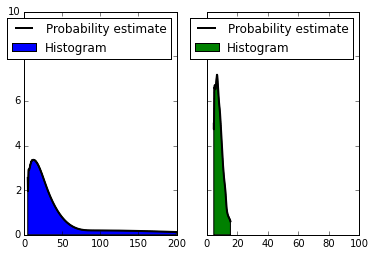

In [25]:
# Check that the histograms and probabilities match
fig, (ax1,ax2) = plt.subplots(1, 2, sharey = True)

ax1.hist(MWL, bins = binsL, weights = splLcorr(MWL), histtype = 'stepfilled', label = 'Histogram')
ax1.plot(MWL, splLcorr(MWL), 'k', linewidth = '2', label = 'Probability estimate')

ax2.hist(MWS, bins = binsS, weights = splScorr(MWS), histtype = 'stepfilled', color = 'green', label = 'Histogram')
ax2.plot(MWS, splScorr(MWS), 'k', linewidth = '2', label = 'Probability estimate')

ax1.set_xlim((0, 200))
ax2.set_xlim((0, 100))

ax1.set_ylim((0, 10))

ax1.legend()
ax2.legend()
plt.show()

Now, convert the histograms to probability mass densities.

### Normalizing the histograms to get probability mass densities

By definition, the sum of the probabilities of the histogram bins times their width must be one. This can be achieved by dividing by a constant, a technique known as *normalization*. This is easily done in numpy by setting the *density* argument of np.histogram to **True**.

In [26]:
# I don't need the bins output because I already have it
histL, _ = np.histogram(MWL, bins = binsL, weights = splLcorr(MWL), density = True)
histS, _ = np.histogram(MWS, bins = binsS, weights = splScorr(MWS), density = True)

# Check that the probability mass densities really are normalized (they should sum to 1 or very close to it)
diffL = np.diff(binsL)
diffS = np.diff(binsS)

print('Integral of Hela L probability mass density: {0}'.format(np.sum(histL * diffL)))
print('Integral of Hela S probability mass density: {0}'.format(np.sum(histS * diffS)))


Integral of Hela L probability mass density: 0.9999999999999999
Integral of Hela S probability mass density: 1.0


# What are the statistical measures of these distributions?

 The mean of a probability mass density $p \left( L \right)$ is simply
 
 \begin{equation*}
 \bar{L} = \sum_{i=0}^{N} L_{i} p \left( L_i \right) \Delta L
 \end{equation*}
 
 To compute this, I need to multiply the midpoint of each bin for the genomic length of the telomeres with its probability in the histL and histS arrays, and then sum them.

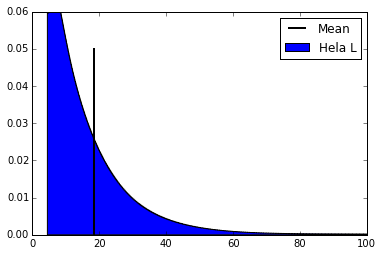

Mean of Hela L: 18.36527754473882


In [27]:
meanL = np.sum(MWL * histL * diffL)
meanS = np.sum(MWS * histS * diffS)

plt.hist(MWL, bins = binsL, weights = splLcorr(MWL), histtype = 'stepfilled', label = 'Hela L', normed = True)
plt.plot([meanL, meanL], [0, 0.05], 'k', label = 'Mean', linewidth = 2)
plt.legend()
plt.xlim(0, 100)
plt.show()

print('Mean of Hela L: {0}'.format(meanL))

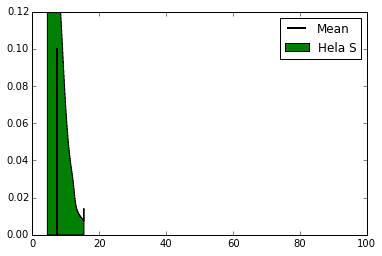

Mean of Hela S: 7.481674064068325


In [28]:
plt.hist(MWS, bins = binsS, weights = splScorr(MWS), histtype = 'stepfilled', color = 'green', label = 'Hela S', normed = True)
plt.plot([meanS, meanS], [0, .1], 'k', label = 'Mean', linewidth = 2)
plt.legend()
plt.xlim(0, 100)
plt.show()

print('Mean of Hela S: {0}'.format(meanS))

### Median values

The median values are the points where the cumulative distributions are 0.5; this means 50% of the area below the curve lies on each side of the median value. For skewed distributions such as these, it is often preferred over the mean as a measure of central tendency.

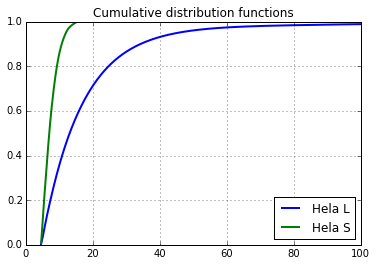

Hela L Median: 13.064535317360777
Hela S Median: 6.961000603805269


In [29]:
cdfL = np.cumsum(histL * diffL)
cdfS = np.cumsum(histS * diffS)

medianL = (max(MWL[cdfL < 0.5]) + min(MWL[cdfL > 0.5])) / 2
medianS = (max(MWS[cdfS < 0.5]) + min(MWS[cdfS > 0.5])) / 2

# Plot the cumulative distribution functions
plt.plot(MWL, cdfL, label = 'Hela L', linewidth = 2)
plt.plot(MWS, cdfS, label = 'Hela S', linewidth = 2)
plt.grid(True)
plt.title('Cumulative distribution functions')
plt.legend(loc = 'best')
plt.xlim(0, 100)
plt.show()

print('Hela L Median: {0}\nHela S Median: {1}'.format(medianL, medianS))

The interesting thing we can see from plotting the CDF's is that, for Hela L, there's still about a 10% chance of picking a telomere at random with a length that's at least double the median value. These long telomeres may be what's contributing to the large dot blot values.

### Where should the tails of the distributions be cropped?

The long tails in the distributions probably aren't real. I can aribitrarily say I want to crop the distributions at the point where the probability drops below 1% of the max. **This requires renormalizing the distributions after cropping, so I'll have to backtrack a few steps.** I'll do this later, if I think it's important.

### Estimate the standard deviations

In [30]:
# Second central moments of the distributions
secondCentMomL = np.sum((MWL - meanL)**2 * histL * diffL)
secondCentMomS = np.sum((MWS - meanS)**2 * histS * diffS)

# Standard deviations of the distributions
stdL = np.sqrt(secondCentMomL)
stdS = np.sqrt(secondCentMomS)

print('Hela L standard deviation: {0:.2f}'.format(stdL))
print('Hela S standard deviation: {0:.2f}'.format(stdS))

Hela L standard deviation: 18.55
Hela S standard deviation: 2.27


# Maximum entropy distributions (redo the uniform distribution part at the end)

If all we know is the mean and standard deviation, maximum entropy states we should choose a Gaussian distribution for the probability. Here's what the equivalent Gaussian's look like relative to the measured probabilities.

In [31]:
from scipy.stats import norm

In [32]:
# Define Gaussians with the measured moments
maxEntL = norm(loc = meanL, scale = stdL)
maxEntS = norm(loc = meanS, scale = stdS)

(0, 0.04)

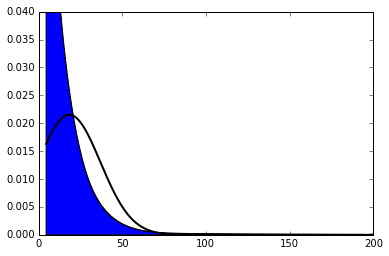

In [33]:
plt.hist(MWL, bins = binsL, weights = splLcorr(MWL), histtype = 'stepfilled', label = 'Hela L', normed = True)
plt.plot(MWL, maxEntL.pdf(MWL), linewidth = 2, color = 'black')
plt.ylim((0, 0.04))

The Gaussian with these parameters does not look very good. Why?

We also know, though, the the length can't be less than zero. This means that this maximum entropy model, which involves plugging in the mean and standard deviation into a Gaussian, is not likely correct.

I also know the long tail at high genomic lengths is probably due to junk in the gel track (extra radio labels, undigested DNA, etc... I can see smears sometimes in the ladders), so the long tails should not be weighted so heavily. In fact, I would expect the larger the value of the distribution, the higher the weight we can place on the distribution. So really, we know quite a lot more than the mean and standard deviation.

Originally, I used a uniform distribution with edges set to the full width half max of the corrected distributions above. **This step imposes few assumptions on the distribution given what we know: the Southern blot data, the model to get the probability of genomic lengths, the fact that the genomic length can't be less than zero, and undigested material leads to a long tail in the measured distributions.**

This means I may have been originally over-weighting mid-range telomeres, as seen in the plot below.

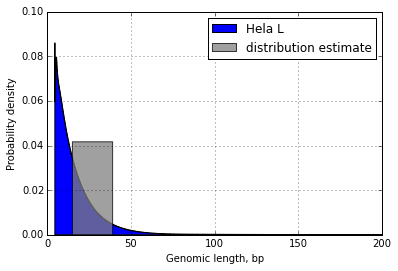

In [34]:
# Plot the histogram between the points correspoinding to half its maximum
plt.hist(MWL, bins = binsL, weights = splLcorr(MWL), histtype = 'stepfilled', label = 'Hela L', normed = True)

# Plot the approximate distribution to use for the simulations
plt.hist([26.5, 27.5], bins = [15, 27, 39], histtype = 'stepfilled', color = 'gray', alpha = 0.75, label = 'distribution estimate', normed = True)
plt.legend()
plt.xlabel('Genomic length, bp')
plt.ylabel('Probability density')
plt.ylim(0, 0.1)
plt.grid()
plt.show()

For the simulations, I originally used the gray distribution estimate above, which as a mean of about 25 kb and a width of about 12 kb.

# How many base pairs can we expect?

The dot blot intensities should be proportional to the total amount of DNA in the blot: this is equivalent to randomly sampling from the above distributions a large number of times and adding the total amount of DNA together.

We can run a numerical experiment to see how many base pairs total we get by doing such an experiment. Being able to select random numbers from this distribution, though, requires converting between CDF's, which isn't exactly straight forward for non-analytical distributions.

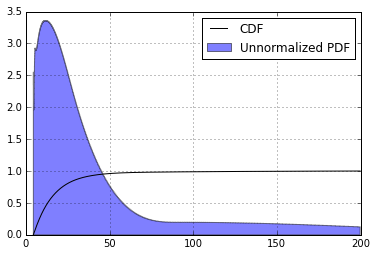

In [35]:
# Plot the cumulative distribution and its unnormalized PDF
plt.plot(MWL, cdfL, color = 'black', label = 'CDF')
plt.hist(MWL, binsL, weights = splLcorr(MWL), color = 'blue', alpha = 0.5, histtype = 'stepfilled', label = 'Unnormalized PDF')
plt.grid(True)
plt.legend()
plt.show()

In [36]:
from scipy.interpolate import interp1d

# Write function that returns a MW value for a given CDF value
def cdf2MW(MW, cdf, cumValue):
    """MW       : array of molecular weight values
       cdf      : array of cdf values
       cumValue : value of the cumulative distribution to interpolate
    """
    if cumValue < min(cdf):
        return min(cdf)
    elif cumValue > max(cdf):
        return max(cdf)
    else:
        f = interp1d(cdf, MW)
        return f(cumValue)

# Check that it works
print('Interpolated x-value at cdf = 0.6 for Hela L: {0}'.format(cdf2MW(MWL, cdfL, 0.6)))
print('Bin location just below cdf = 0.6: {0}'.format(max(MWL[cdfL < 0.6])))
print('Bin location just above cdf = 0.6: {0}'.format(min(MWL[cdfL > 0.6])))

Interpolated x-value at cdf = 0.6 for Hela L: 15.826118584088183
Bin location just below cdf = 0.6: 15.784984282107533
Bin location just above cdf = 0.6: 15.90826703144472


In [37]:
# Now, run the numerical experiments.
# Generate a random uniform number between 0 and 1;
# Then, find the corresponding value from the CDF.
numTelomeres = int(1e6) # Number of telomeres to generate
randNums     = np.random.rand(numTelomeres)
experimentL  = np.zeros(numTelomeres)
experimentS  = np.zeros(numTelomeres)
maxL         = np.max(MWL)
maxS         = np.max(MWS)

# DO NOT do a list comprehension since the arrays are so large
for ctr in range(numTelomeres):
    experimentL[ctr] = cdf2MW(MWL, cdfL, randNums[ctr])
    experimentS[ctr] = cdf2MW(MWS, cdfS, randNums[ctr]) 

In [38]:
# What are the outcomes?
totalL = np.sum(experimentL)
totalS = np.sum(experimentS)

In [39]:
print('Total number of basepairs, Hela L: {0}'.format(totalL))
print('Total number of basepairs, Hela S: {0}'.format(totalS))
print('Ratio of totals: {0}'.format(totalL / totalS))
print('Ratio of means:  {0}'.format(meanL / meanS))

Total number of basepairs, Hela L: 18262345.26857087
Total number of basepairs, Hela S: 7419825.379247645
Ratio of totals: 2.4612904394823687
Ratio of means:  2.4547016332802256


So, even for very skewed distributions, **the ratio of the total amount of telomeric DNA is equal to the ratio of the means of the distribution.**

This means that the ratio of the dot blot intensities should equal the ratio of the mean values from the Southern blots. **Because the dot blot ratios are ~3 and we can place a high degree of belief in the dot blots, this means that the Southern blots are likely biased.** The different ways to estimate the means described above also corroborates this fact. I expect that the Hela L telomeres are more heavily biased since their spread in lengths is much larger than Hela S. Also, since correcting for the telomere length in the Southern blots doesn't change the mean by a large amount, I would guess that most of the bias in the Southern blots comes from variation in the hybridization at long telomere lengths.

# Can experimentL and experimentS be used as telomere length data?

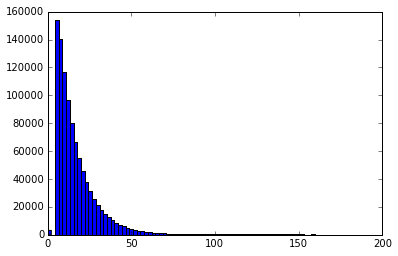

In [40]:
plt.hist(experimentL, bins = 90)
plt.show()

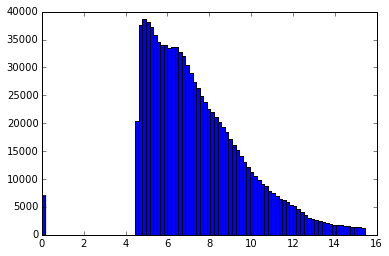

In [41]:
plt.hist(experimentS, bins = 90)
plt.show()